In [1]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from utility import *
%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('data/train_transaction.csv')
df.index = df['TransactionID']
del df['TransactionID']

In [6]:
df.sample(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
3006877,3006877,0,515683,105.000,W,17662,543.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3183617,3183617,0,4417492,209.950,W,7638,174.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3540061,3540061,0,14605536,36.950,W,9753,310.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3145969,3145969,0,3344227,29.000,W,16661,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3015701,3015701,0,738265,15.000,H,7861,494.0,150.0,visa,226.0,...,1.0,50.0,50.0,50.0,0.0,0.0,0.0,50.0,50.0,50.0
3348886,3348886,1,8975533,554.000,W,8695,170.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3413659,3413659,0,10785846,90.007,C,8404,156.0,146.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3289783,3289783,0,7495073,142.000,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3207645,3207645,0,5181094,107.950,W,2884,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
categoricalColumns = df.columns[df.dtypes==object]
numericColumns = df.columns[df.dtypes!=object]

(array([109.,  69.,   0.,  19.,   1.,  14.,   1.,   0., 112.,  55.]),
 array([0.        , 0.09362837, 0.18725675, 0.28088512, 0.3745135 ,
        0.46814187, 0.56177024, 0.65539862, 0.74902699, 0.84265537,
        0.93628374]),
 <a list of 10 Patch objects>)

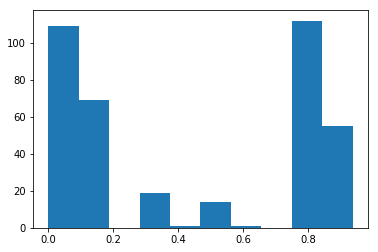

In [8]:
percentNa = df[numericColumns].isna().sum()/ len(df)
plt.hist(percentNa)

In [9]:
lowPercentColumns = numericColumns[percentNa < .2]
midPercentColumns = numericColumns[(percentNa > .2) & (percentNa < .7)]
midAndLowPercentColumns = numericColumns[percentNa < .7]

In [7]:
for column in lowPercentColumns:
    df[column] = df[column].fillna(df[column].mean())

In [8]:
for column in midPercentColumns:
    df["%s_isnan"%column] = df[column].isna()
    df[column] = df[column].fillna(df[column].mean())

(array([213.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 112.,  55.]),
 array([0.        , 0.09362837, 0.18725675, 0.28088512, 0.3745135 ,
        0.46814187, 0.56177024, 0.65539862, 0.74902699, 0.84265537,
        0.93628374]),
 <a list of 10 Patch objects>)

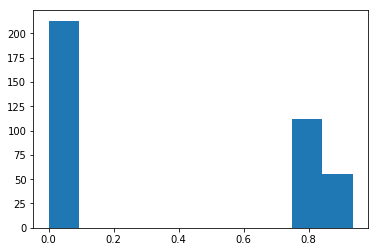

In [9]:
percentNa = df[numericColumns].isna().sum()/ len(df)
plt.hist(percentNa)

In [10]:
tmp = categoricalColumns.to_list()
del tmp[3:5]
dfCategoricalExceptEmailDummied = pd.get_dummies(df[tmp])

In [11]:
dfCategoricalExceptEmailDummied.columns

Index(['ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_american express', 'card4_discover',
       'card4_mastercard', 'card4_visa', 'card6_charge card', 'card6_credit',
       'card6_debit', 'card6_debit or credit', 'M1_F', 'M1_T', 'M2_F', 'M2_T',
       'M3_F', 'M3_T', 'M4_M0', 'M4_M1', 'M4_M2', 'M5_F', 'M5_T', 'M6_F',
       'M6_T', 'M7_F', 'M7_T', 'M8_F', 'M8_T', 'M9_F', 'M9_T'],
      dtype='object')

In [12]:
dfEmails = df[['P_emaildomain', 'R_emaildomain']]

In [13]:
#getEmailService = lambda x: x.split('.', maxsplit=1)[0] if type(x)==str else ''
def getEmailService(x):
    if type(x) != str:
        return ''
    xSplit = x.split('.', maxsplit=1)
    return xSplit[0].replace('ymail', 'yahoo')
def getEmailDomain(x):
    if type(x) != str:
        return ''
    xSplit = x.split('.', maxsplit=1)
    if len(xSplit) > 1:
        return xSplit[1]
    return ''
dfEmails['P_emailservice'] = dfEmails['P_emaildomain'].map(getEmailService)
dfEmails['P_emaildomain']  = dfEmails['P_emaildomain'].map(getEmailDomain)
dfEmails['R_emailservice'] = dfEmails['R_emaildomain'].map(getEmailService)
dfEmails['R_emaildomain']  = dfEmails['R_emaildomain'].map(getEmailDomain)

/home/bzr0014/envs/AI/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/bzr0014/envs/AI/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/bzr0014/envs/AI/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [14]:
PemailServiceCount = collections.Counter(dfEmails['P_emailservice'])
PemailDomainCount = collections.Counter(dfEmails['P_emaildomain'])
RemailServiceCount = collections.Counter(dfEmails['R_emailservice'])
RemailDomainCount = collections.Counter(dfEmails['R_emaildomain'])

In [15]:
PemailServicePercent = {key: value/len(dfEmails) for key, value in PemailServiceCount.items()}
PemailDomainPercent = {key: value/len(dfEmails) for key, value in PemailDomainCount.items()}
RemailServicePercent = {key: value/len(dfEmails) for key, value in RemailServiceCount.items()}
RemailDomainPercent = {key: value/len(dfEmails) for key, value in RemailDomainCount.items()}

In [16]:
PemailDomainPercent

{'': 0.16078843092762557,
 'co.jp': 5.418769262031361e-05,
 'co.uk': 0.00027263182849595284,
 'com': 0.7893470383039253,
 'com.mx': 0.0038811934839299623,
 'de': 0.0008568428895587089,
 'es': 0.0014850814508754698,
 'fr': 0.0008365225048260913,
 'net': 0.04155857350899177,
 'net.mx': 0.00035052663663765366,
 'rr.com': 0.0005689707725132929}

In [17]:
highlyOccuringEmailServices = set()
for key in PemailServicePercent:
    if PemailServicePercent[key] > .01:
        highlyOccuringEmailServices.add(key)
for key in RemailServicePercent:
    if RemailServicePercent[key] > .01:
        highlyOccuringEmailServices.add(key)       

In [18]:
highlyOccuringEmailServices

{'', 'anonymous', 'aol', 'comcast', 'gmail', 'hotmail', 'icloud', 'yahoo'}

In [19]:
highlyOccuringEmailDomains = set()
for key in PemailDomainPercent:
    if PemailDomainPercent[key] > .01:
        highlyOccuringEmailDomains.add(key)
for key in RemailDomainPercent:
    if RemailDomainPercent[key] > .01:
        highlyOccuringEmailDomains.add(key)       

In [20]:
highlyOccuringEmailDomains

{'', 'com', 'net'}

In [21]:
dfEmails['P_emaildomain'] = dfEmails['P_emaildomain'].map(lambda x: x if x in highlyOccuringEmailDomains else 'other')
dfEmails['R_emaildomain'] = dfEmails['R_emaildomain'].map(lambda x: x if x in highlyOccuringEmailDomains else 'other')

/home/bzr0014/envs/AI/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/bzr0014/envs/AI/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
dfEmails['P_emailservice'] = dfEmails['P_emailservice'].map(lambda x: x if x in highlyOccuringEmailServices else 'other')
dfEmails['R_emailservice'] = dfEmails['R_emailservice'].map(lambda x: x if x in highlyOccuringEmailServices else 'other')

/home/bzr0014/envs/AI/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/bzr0014/envs/AI/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
dfEmailDummied = pd.get_dummies(dfEmails)

In [24]:
dfEmailDummied.columns

Index(['P_emaildomain_', 'P_emaildomain_com', 'P_emaildomain_net',
       'P_emaildomain_other', 'R_emaildomain_', 'R_emaildomain_com',
       'R_emaildomain_net', 'R_emaildomain_other', 'P_emailservice_',
       'P_emailservice_anonymous', 'P_emailservice_aol',
       'P_emailservice_comcast', 'P_emailservice_gmail',
       'P_emailservice_hotmail', 'P_emailservice_icloud',
       'P_emailservice_other', 'P_emailservice_yahoo', 'R_emailservice_',
       'R_emailservice_anonymous', 'R_emailservice_aol',
       'R_emailservice_comcast', 'R_emailservice_gmail',
       'R_emailservice_hotmail', 'R_emailservice_icloud',
       'R_emailservice_other', 'R_emailservice_yahoo'],
      dtype='object')

In [25]:
dfEmailDummied.values.shape

(590540, 26)

In [26]:
df[midAndLowPercentColumns].values.shape

(590540, 213)

In [27]:
dfCategoricalExceptEmailDummied.values.shape

(590540, 32)

In [32]:
finalArray = np.hstack([
    dfCategoricalExceptEmailDummied.values,
    dfEmailDummied.values,
    df[midAndLowPercentColumns].values
]).astype('float32')

In [33]:
import pickle
with open('cleaned_input.np', 'wb') as f:
    pickle.dump(finalArray, f)

In [34]:
allColumns = dfCategoricalExceptEmailDummied.columns.tolist() + dfEmailDummied.columns.tolist() + df[midAndLowPercentColumns].columns.tolist()

In [35]:
with open('cleaned_colunms', 'wb') as f:
    pickle.dump(allColumns, f)